In [11]:
# global settings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

FIGRATIO = 3 / 4
FIGWIDTH = 5  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 14

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

In [13]:
pd.options.display.float_format = '{:.0f}'.format
MICROSECOND = 1e6 # second to microsecon conversion

# experiment settings
SINK_STAGE = 'task::MapBatches(encode_and_upload)'
NUM_BATCHES = 50
BATCH_SIZE = 20

### Ray Data (dynamic, static, fused, staged)

In [70]:
def process(filename, sink_stage=SINK_STAGE, num_batches=NUM_BATCHES, batch_size=BATCH_SIZE, window_size=5):
    df = pd.read_json(filename)
    start_time = df["ts"].min()
    df = df[df['cat'] == sink_stage]
    df['time_from_start'] = (df['ts'] + df['dur'] - start_time) / MICROSECOND
    print(f"[Ray Data {filename.split("-")[1][:-5]}]", "Actual throughput: {:.3f}".format(NUM_BATCHES * BATCH_SIZE / df['time_from_start'].max()))
    df['time_from_start'] = pd.to_timedelta(df['time_from_start'], unit='s')
    df.sort_values('time_from_start', inplace=True)

    df['number_of_rows_finished'] = np.arange(1, num_batches + 1) * batch_size
    df.set_index("time_from_start", inplace=True)

    df["tput"] = df['number_of_rows_finished'].diff() / df.index.total_seconds().diff()
    df['tput'] = df['tput'].fillna(0)

    time_vals = df.index.total_seconds()
    tput_vals = df['tput'].rolling(window=window_size).mean().fillna(0)
    tput_vals = df['tput'].fillna(0)

    # fill in the tput_vals with 0s for the time_vals that are not in the index
    filled_time_vals = []
    filled_tput_vals = []
    
    for i in np.arange(0, int(time_vals[0]), window_size):
        filled_time_vals.append(i)
        filled_tput_vals.append(0)
    filled_time_vals.extend(time_vals)  
    filled_tput_vals.extend(tput_vals)
    
    return filled_time_vals, filled_tput_vals

In [71]:
time_raydata_dynamic, tput_raydata_dynamic = process('results/radar-dynamic.json')
time_raydata_static, tput_raydata_static = process('results/radar-static.json')
time_raydata_fused, tput_raydata_fused = process('results/radar-fused.json', sink_stage='task::MapBatches(FusedProcessor)', num_batches=10)

[Ray Data dynamic] Actual throughput: 3.307
[Ray Data static] Actual throughput: 3.651
[Ray Data fused] Actual throughput: 1.019


In [72]:
df = pd.read_json('results/radar-staged-new.json')
start_time = df["ts"].min()
df = df[df['cat'] == SINK_STAGE]
df['time_from_start'] = (df['ts'] + df['dur'] - start_time) / MICROSECOND
print("[Ray Data Staged] Actual throughput: {:.3f}".format(NUM_BATCHES * BATCH_SIZE / df['time_from_start'].max()))

df['time_from_start'] = pd.to_timedelta(df['time_from_start'], unit='s')
df.sort_values('time_from_start', inplace=True)
df['number_of_rows_finished'] = np.arange(1, NUM_BATCHES + 1) * BATCH_SIZE
df.set_index("time_from_start", inplace=True)
resampled = df['number_of_rows_finished'].resample('0.7s').mean().bfill()

time_vals = resampled.index.total_seconds()
row_vals = resampled

tput_vals = row_vals.diff() / time_vals.diff()
tput_vals = tput_vals.fillna(0)
filled_time_vals = []
filled_tput_vals = []

for i in np.arange(0, int(time_vals[0]), 5):
    filled_time_vals.append(i)
    filled_tput_vals.append(0)

filled_time_vals.extend(time_vals)
filled_tput_vals.extend(tput_vals)

filled_tput_vals = pd.Series(filled_tput_vals).expanding().mean()
filled_tput_vals = filled_tput_vals.rolling(window=35).mean().fillna(0)
time_raydata_staged, tput_raydata_staged = filled_time_vals, filled_tput_vals

[Ray Data Staged] Actual throughput: 2.375


### Spark

In [66]:
df = pd.read_csv('results/spark_staged_log.log', names=['number_of_rows_finished', 'time'])
df['number_of_rows_finished'] = df['number_of_rows_finished'].cumsum()
df['time_from_start'] = df['time'] - df['time'].min()
print("[Spark Staged] Actual throughput: {:.3f}".format(df['number_of_rows_finished'].max() / df['time_from_start'].max()))

df['time_from_start'] = pd.to_timedelta(df['time_from_start'], unit='s')
df.set_index("time_from_start", inplace=True)

resampled = df['number_of_rows_finished'].resample('0.145s').mean().ffill()
df.head(10)

[Spark Staged] Actual throughput: 2.497


,number_of_rows_finished,time
time_from_start,,
0 days 00:00:00,0,1733686495
0 days 00:05:34.072309017,1,1733686829
0 days 00:05:34.547122955,2,1733686830
0 days 00:05:35.006860018,3,1733686830
0 days 00:05:35.433638573,4,1733686831
0 days 00:05:35.857418299,5,1733686831
0 days 00:05:36.314226627,6,1733686832
0 days 00:05:36.742178202,7,1733686832
0 days 00:05:37.171913385,8,1733686833


In [73]:
time_vals = resampled.index.total_seconds()
row_vals = resampled

tput_vals = row_vals.diff() / time_vals.diff()
tput_vals = tput_vals.fillna(0)
filled_time_vals = []
filled_tput_vals = []

# Fill in the tput_vals with 0s for the time_vals that are not in the index
for i in np.arange(0, int(time_vals[0]), 5):
    filled_time_vals.append(i)
    filled_tput_vals.append(0)

# Add actual time_vals and tput_vals
filled_time_vals.extend(time_vals)
filled_tput_vals.extend(tput_vals)

# smoothing
filled_tput_vals = pd.Series(filled_tput_vals)
filled_tput_vals = filled_tput_vals.rolling(window=1000).mean().fillna(0)
time_spark_staged = filled_time_vals
tput_spark_staged = filled_tput_vals

### Flink

In [74]:
df = pd.read_json('results/flink.json')
start_time = df["ts"].min()
df = df[df['cat'].str.contains('consumer')]

df['time_from_start'] = (df['ts'] + df['dur'] - start_time) / MICROSECOND
print("[Flink] Actual throughput: {:.3f}".format(NUM_BATCHES * BATCH_SIZE / df['time_from_start'].max()))
df['time_from_start'] = pd.to_timedelta(df['time_from_start'], unit='s')
df.sort_values('time_from_start', inplace=True)

df['number_of_rows_finished'] = np.arange(1, NUM_BATCHES + 1) * BATCH_SIZE
df.set_index("time_from_start", inplace=True)

df["tput"] = df['number_of_rows_finished'].diff() / df.index.total_seconds().diff()
df['tput'] = df['tput'].fillna(0)

time_vals = df.index.total_seconds()
tput_vals = df['tput'].rolling(window=5).mean().fillna(0)
tput_vals = df['tput'].fillna(0)

# fill in the tput_vals with 0s for the time_vals that are not in the index
filled_time_vals = []
filled_tput_vals = []

for i in np.arange(0, int(time_vals[0]), 5):
    filled_time_vals.append(i)
    filled_tput_vals.append(0)
filled_time_vals.extend(time_vals)  
filled_tput_vals.extend(tput_vals)


time_flink = filled_time_vals
tput_flink = filled_tput_vals

[Flink] Actual throughput: 0.771


### Final Plot


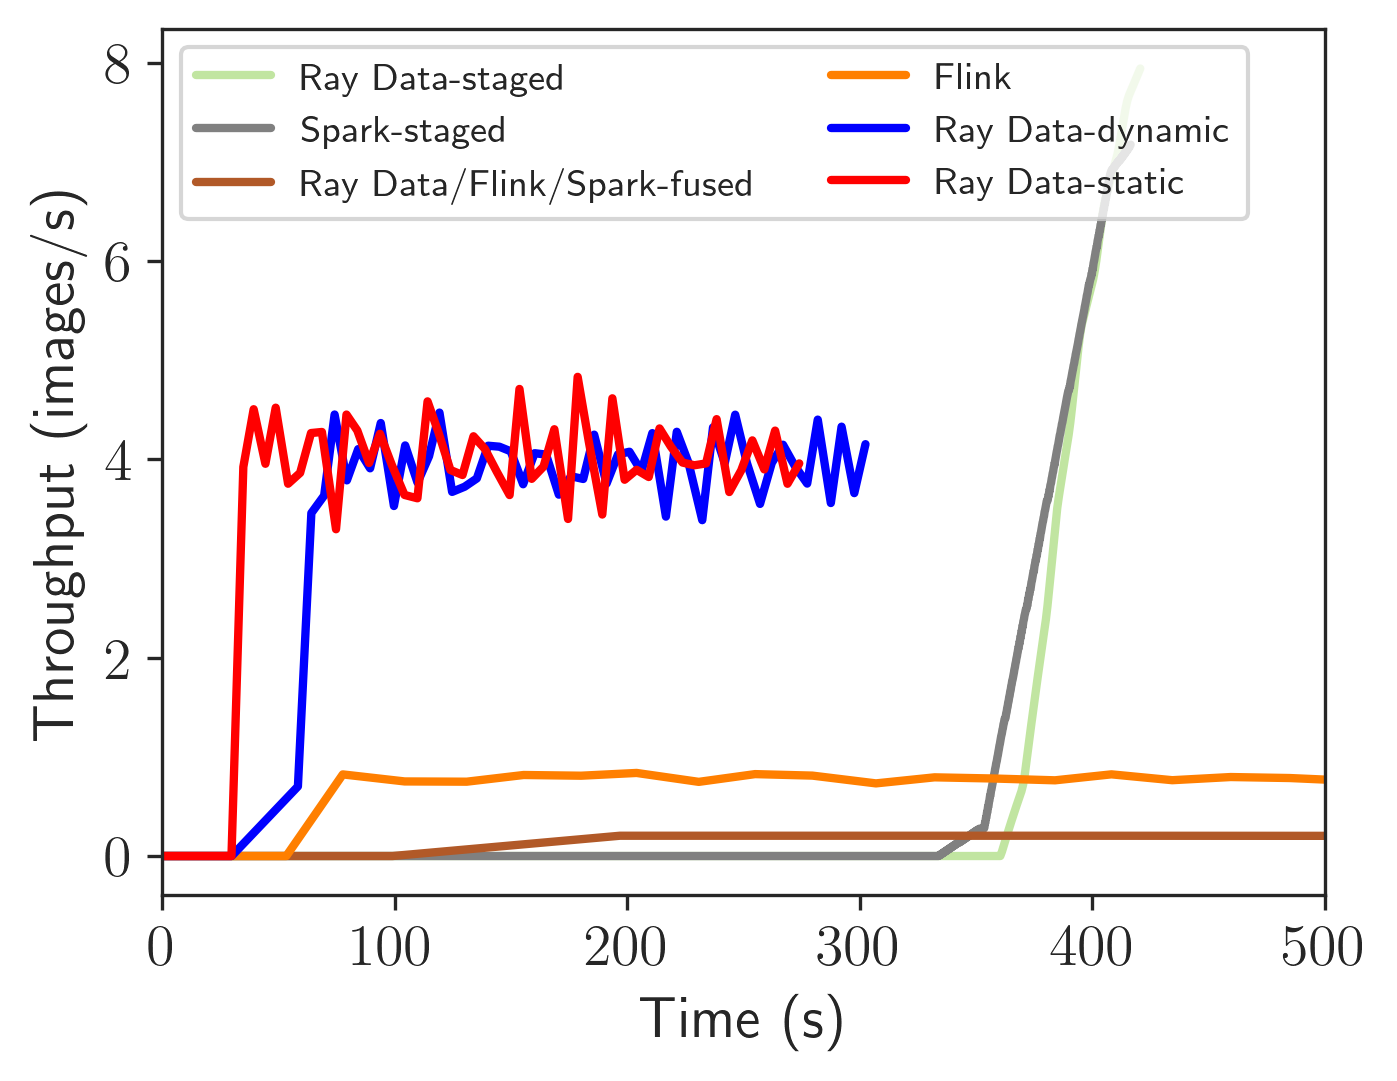

In [69]:
fig, ax = plt.subplots()

LINEWIDTH = 2

ax.plot(time_raydata_staged, tput_raydata_staged, label="Ray Data-staged", color=COLORS[2], linewidth=LINEWIDTH, alpha=0.8)
ax.plot(time_spark_staged, tput_spark_staged, label="Spark-staged", color='gray', linewidth=LINEWIDTH, alpha=1)
ax.plot(time_raydata_fused, tput_raydata_fused, label="Ray Data/Flink/Spark-fused", color=COLORS[11], linewidth=LINEWIDTH, alpha=1)

ax.plot(time_flink, tput_flink, label="Flink", color=COLORS[7], linewidth=LINEWIDTH, alpha=1)
ax.plot(time_raydata_dynamic, tput_raydata_dynamic, label="Ray Data-dynamic", color='blue', linewidth=LINEWIDTH, alpha=1)
ax.plot(time_raydata_static, tput_raydata_static, label="Ray Data-static", color='red', linewidth=LINEWIDTH, alpha=1)

plt.xlabel("Time (s)")
plt.ylabel("Throughput (images/s)")
plt.xlim(0, 500)

plt.legend(fontsize=9, loc='center right', bbox_to_anchor=(0.45, 0.48, 0.5, 0.8), ncols=2)
# plt.savefig("image-generation-rd.pdf", bbox_inches='tight')
plt.show()